# IE 8990 Time Series and Forecating Course 
## Project I 

Analyzing household power consumption data to forecast the individual household electric power consumption using the naive base methods and advanced statistical techniques.

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [24]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

## Reading and preprocessing the data 
Source: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [3]:
df = pd.read_csv('./household_power_consumption.txt', sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [5]:
df.shape

(2075259, 9)

In [6]:
# Check for missing values
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [8]:
# Plot Sub_metering_3 to see if there is a noticeable gap in missing values. 
# Useful to see if there are a lot of consecutive 
# missing values.

na_groups = df['Sub_metering_3'].notna().cumsum()[df['Sub_metering_3'].isna()]
len_consecutive_na = na_groups.groupby(na_groups).agg(len)
len_consecutive_na

Sub_metering_3
6839          2
19722         2
41828         1
61904         1
98248         2
           ... 
1845496       1
1868395       1
1916303    7226
1964211    5237
2001433       1
Name: Sub_metering_3, Length: 71, dtype: int64

In [9]:
longest_na_gap = len_consecutive_na.max()
longest_na_gap

7226

In [10]:
# Remove Sub_metering_3 column as the length of consecutive missing values
# is too large to fill with another value

df = df.drop(['Sub_metering_3'], axis=1)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000


In [11]:
df.dtypes

Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
dtype: object

In [13]:
# Transform all values to numeric except for date and time

cols_to_convert = df.columns[2:]

df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [14]:
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
dtype: object

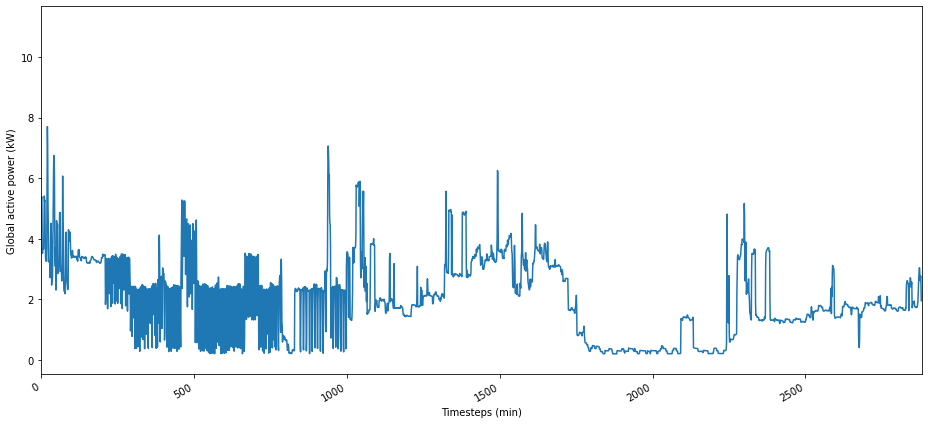

In [15]:
# Plot first 24h (2880 min) of target

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['Global_active_power'])
ax.set_xlabel('Timesteps (min)')
ax.set_ylabel('Global active power (kW)')
ax.set_xlim(0, 2880)

fig.autofmt_xdate()
plt.tight_layout()

In [16]:
# Create new datetime column to have date formatted correctly
df.loc[:,'datetime'] = pd.to_datetime(df.Date.astype(str) + ' ' + df.Time.astype(str))

# Drop old date and tiem columns
df = df.drop(['Date', 'Time'], axis=1)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,2006-12-16 17:28:00


In [17]:
# Sample daily sum to see if we get a more visible pattern
daily_df = df.resample('D', on='datetime').sum()
#losing resolution by changing from minutes to day:under-sampling
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0


In [18]:
ldaily_df=len(daily_df)
ldaily_df

1457

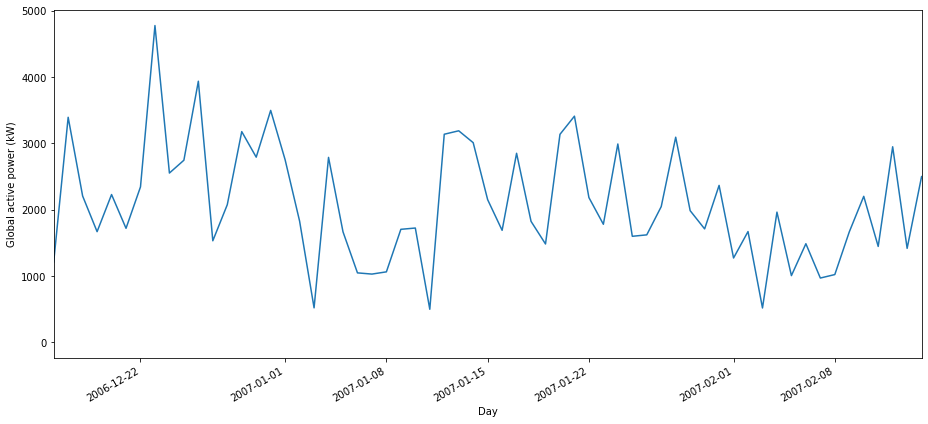

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(daily_df['Global_active_power'])
ax.set_xlabel('Day')
ax.set_ylabel('Global active power (kW)')

start_date = daily_df.index[0]
end_date = start_date + pd.Timedelta(days=60)

ax.set_xlim(start_date, end_date)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [18]:
daily_df.to_csv('clean_household_power_consumption.csv', header=True, index=False)

## Feature engineering 

In [19]:
daily_df = pd.read_csv('clean_household_power_consumption.csv')
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
0,1209.176,34.922,93552.53,5180.8,0.0,546.0
1,3390.460,226.006,345725.32,14398.6,2033.0,4187.0
2,2203.826,161.792,347373.64,9247.2,1063.0,2621.0
3,1666.194,150.942,348479.01,7094.0,839.0,7602.0
4,2225.748,160.998,348923.61,9313.0,0.0,2648.0


In [20]:
daily_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,1457.0,1535.363666,633.773181,0.0,1147.396,1528.76,1885.964,4773.386
Global_reactive_power,1457.0,174.005218,54.691142,0.0,139.544,169.68,202.004,417.834
Voltage,1457.0,338742.830577,50279.394083,0.0,345578.390,346900.63,348232.950,356306.410
Global_intensity,1457.0,6508.973644,2631.461795,0.0,4941.600,6483.60,7949.200,20200.400
Sub_metering_1,1457.0,1577.992450,1587.823466,0.0,437.000,1106.00,2187.000,11178.000
Sub_metering_2,1457.0,1826.376802,2087.133542,0.0,419.000,667.00,2686.000,12109.000


In [27]:
print(np.isinf(daily_df).any())


Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
dtype: bool


## Splitting the data and scaling it

#### For Project 1

The data is split into 70% trainning and 30% testing datasets as follows:

In [28]:
n = len(daily_df)
print(n)
# Split 70:30 (train:test)
Pr1_train_df = daily_df[0:int(n*0.7)]
Pr1_test_df = daily_df[int(n*0.7):]
len_Pr1_train = len(Pr1_train_df)
print(len_Pr1_train)
Pr1_train_df.shape, Pr1_test_df.shape

1457
1019


((1019, 6), (438, 6))

In [29]:
from sklearn.preprocessing import MinMaxScaler
#scaling them to small size to use them in neural network as a weight
scaler = MinMaxScaler()
scaler.fit(Pr1_train_df)

Pr1_train_df[Pr1_train_df.columns] = scaler.transform(Pr1_train_df[Pr1_train_df.columns])
Pr1_test_df[Pr1_test_df.columns] = scaler.transform(Pr1_test_df[Pr1_test_df.columns])

## Saving the datasets to CSV files 

In [24]:
# for project1
Pr1_train_df.to_csv('train_project1.csv', index=False, header=True)
Pr1_test_df.to_csv('test_project1.csv', index=False, header=True)



## Naive Base Models to forecast Individual household electric power consumption 
### 1) Historical Mean Prediction

In [30]:
# finding the historical mean 
historical_mean = np.mean(Pr1_train_df['Global_active_power'])
historical_mean

0.3260019500327602

In [31]:
# creating new column for historical mean predictions of Individual household electric power consumption
Pr1_test_df.loc[:, 'pred_mean'] = historical_mean
Pr1_test_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,pred_mean
datetime,,,,,,,
2009-09-30,0.371379,0.508039,0.977166,0.372488,0.086778,0.667272,0.326002
2009-10-01,0.440557,0.387077,0.992196,0.434051,0.252997,0.354117,0.326002
2009-10-02,0.407221,0.277220,0.988283,0.398071,0.100913,0.021719,0.326002
2009-10-03,0.384677,0.274994,0.982880,0.380715,0.000000,0.023206,0.326002
2009-10-04,0.385913,0.396789,0.983718,0.379893,0.184022,0.233050,0.326002


Looking at the Individual household electric power consumption predictions using the historical mean method

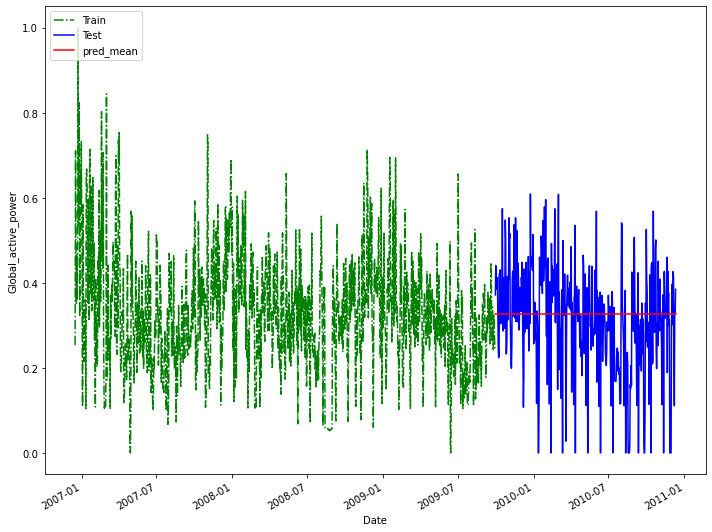

In [34]:
fig, ax = plt.subplots()

ax.plot( Pr1_train_df['Global_active_power'], 'g-.', label= "Train")
ax.plot( Pr1_test_df['Global_active_power'], 'b-', label= "Test")
ax.plot( Pr1_test_df['pred_mean'], 'r-', label= "pred_mean")
ax.set_xlabel('Date')
ax.set_ylabel('Global_active_power')
#ax.axvspan(32, 35, color='#808080', alpha=0.2)
#ax.set_xlim(20, 1456)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

### 2) Last Known Value Prediction 

In [35]:
last = Pr1_train_df['Global_active_power'].iloc[-1]
last

0.240164528910924

In [36]:
Pr1_test_df.loc[:,"pred_last"] = last
last

0.240164528910924

Looking at the Individual household electric power consumption predictions using the last known value method

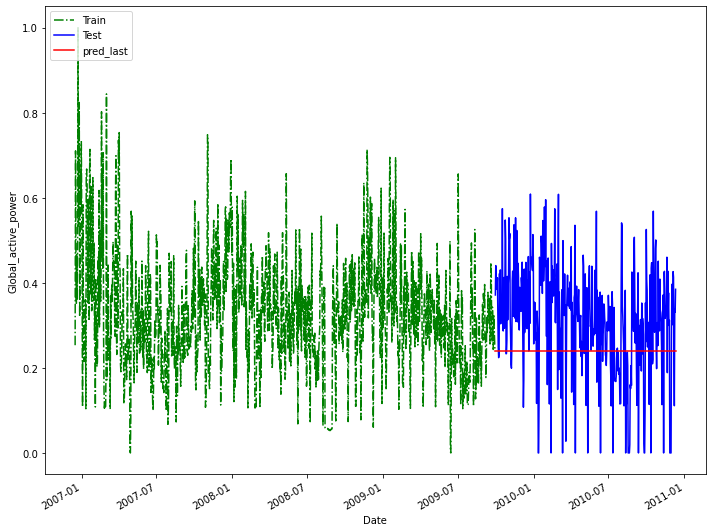

In [38]:
fig, ax = plt.subplots()

ax.plot( Pr1_train_df['Global_active_power'], 'g-.', label= "Train")
ax.plot( Pr1_test_df['Global_active_power'], 'b-', label= "Test")
ax.plot( Pr1_test_df['pred_last'], 'r-', label= "pred_last")
ax.set_xlabel('Date')
ax.set_ylabel('Global_active_power')
#ax.axvspan(32, 35, color='#808080', alpha=0.2)
#ax.set_xlim(20, 1456)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

To compare the performance of these two naive base models, Mean Absolute Percentage Error is used and is defined below

In [39]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true ))) * 100


In [40]:
Pr1_test_df = Pr1_test_df[Pr1_test_df['Global_active_power'] != 0]

# For Historical Mean 
mape_hist_mean = mape(Pr1_test_df['Global_active_power'], Pr1_test_df['pred_mean'])
mape_hist_mean


41.16336440467911

In [41]:
# For Last Known Value
mape_last = mape(Pr1_test_df['Global_active_power'], Pr1_test_df['pred_last'])
mape_last

40.28560222477645

## Checking different properties of the data 

Decomposition of the Individual household electric power consumption data can provide insights about the characteristics of the times series data such as trend and seasonality.  

In [42]:
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv("clean_household_power_consumption.csv", parse_dates=True)
ADF_result = adfuller(df['Global_active_power'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -17.082498241911793
p-value: 7.689461901039393e-30


In [48]:
diff_df = np.diff(df['Global_active_power'], n=1)

In [49]:
diff_ADF_result = adfuller(diff_df)

print(f'ADF Statistic: {diff_ADF_result[0]}')
print(f'p-value: {diff_ADF_result[1]}')

ADF Statistic: -40.13682059718009
p-value: 0.0


P value is very small therefore we reject the null hypothesis and the transfromed data is stationary. 


Let's take a look at the autocorrelation plots 

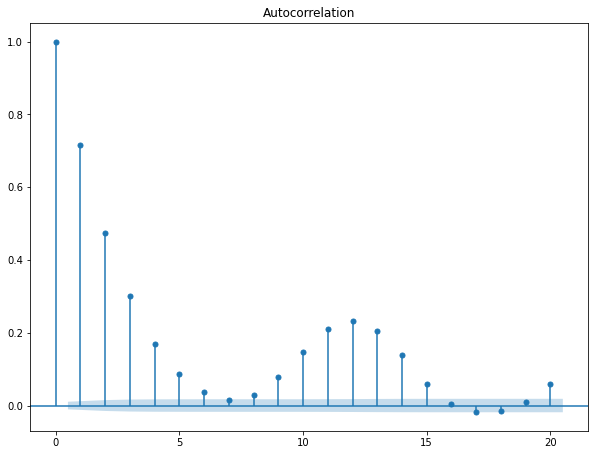

In [50]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['Global_active_power'], lags=20);

From the plot above, there is autocorrelation and the autocorrelation coefficients abruptly become nonsignificant after lag 5 but increase again. Therefore, Individual household electric power consumption data is a random walk.

## SARIMAX forecasting of individual household electric power consumption 

In [51]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [52]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [53]:
target = df['Global_active_power']
exog = df[['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']]

In [54]:
target_train = target[:len_Pr1_train]
exog_train = exog[:len_Pr1_train]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 1, 0, 0)",3794.575521
1,"(0, 3, 0, 2)",3795.203262
2,"(2, 0, 0, 0)",3795.481877
3,"(2, 1, 0, 0)",3795.766765
4,"(3, 0, 0, 0)",3795.912816
...,...,...
251,"(2, 2, 0, 0)",4807.433784
252,"(3, 2, 0, 0)",4811.338869
253,"(2, 3, 0, 0)",4814.298536
254,"(3, 3, 0, 0)",4818.368544


In [55]:
#best_model = SARIMAX(target_train, exog_train, order=(3,0,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model = SARIMAX(target_train, exog_train, order=(1,0,1), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1019
Model:                SARIMAX(1, 0, 1)   Log Likelihood               -1889.288
Date:                 Fri, 05 May 2023   AIC                           3794.576
Time:                         16:40:16   BIC                           3833.988
Sample:                              0   HQIC                          3809.541
                                - 1019                                         
Covariance Type:                   opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Global_reactive_power    -0.0997      0.012     -8.090      0.000      -0.124      -0.076
Voltage               -4.471e-06   1.53e-05     -0.292      0.770   -3.45e-05    2.56e-05


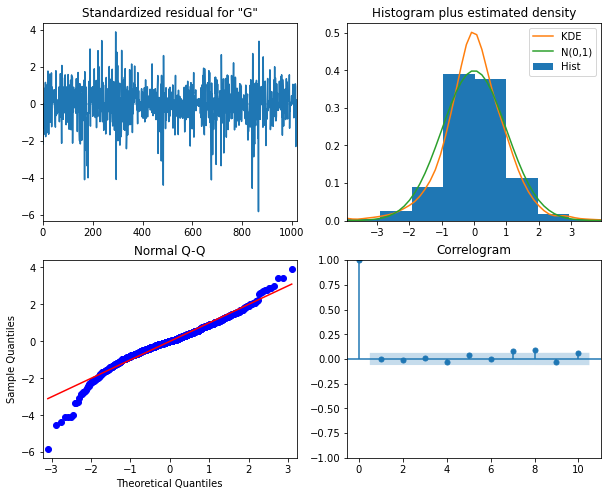

In [56]:
best_model_fit.plot_diagnostics(figsize=(10,8));

Looking at the QQ plot, the residuals follow a normal distribution but there exist some outliers. 

In [57]:
residuals = best_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 10, 1), return_df=False)

print(pvalue)

[0.99870587 0.92110411 0.97498555 0.88380095 0.74477781 0.84404389
 0.28417839 0.02375274 0.03004533]


Since all the p values are greater than 0.05 except the last 2, then we fail to reject the null hypothesis and therefore the residuals at each lag are independent and uncorrelated. 

Therefore, the SARIMAX model does not violate the necessary assumptions and can be used to predict the individual household electric power consumption.

In [58]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,0,2), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [59]:
target_train = target[:len_Pr1_train]
target_test = target[len_Pr1_train:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

KeyboardInterrupt: 

In [131]:
def mape(y_true, y_pred, epsilon=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [132]:

mape_last = mape(pred_df.actual, pred_df.pred_last_value)


mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

54659260997.09314 55023255260.976616


In [ ]:
def mape(y_true, y_pred, epsilon=1e-8):
    return np.mean(np.abs((y_true - y_pred) / y_true )) * 100


mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

In [133]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 45)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

ValueError: Image size of 842x1757139380 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x750 with 1 Axes>

In [ ]:
### (e) Autoregressive Moving Average (ARMA) forecasting


In [65]:
# defining a function to optimize ARIMA 
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [66]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))
train = df['Global_active_power'][:len_Pr1_train]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",15198.057400
1,"(2, 3)",15259.780589
2,"(3, 1)",15266.055619
3,"(3, 2)",15267.278645
4,"(0, 3)",15278.278150
5,"(1, 2)",15278.597429
6,"(2, 2)",15278.985053
7,"(1, 3)",15280.184372
8,"(0, 2)",15280.880484
9,"(2, 1)",15283.751329


In [67]:
model = SARIMAX(train, order=(3,0,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1009
Model:                SARIMAX(3, 0, 3)   Log Likelihood               -7631.346
Date:                 Thu, 27 Apr 2023   AIC                          15276.693
Time:                         19:10:51   BIC                          15311.110
Sample:                              0   HQIC                         15289.768
                                - 1009                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2648      0.092      2.890      0.004       0.085       0.444
ar.L2          0.1057      0.090      1.179      0.238      -0.070       0.281
ar.L3          0.6257      0.055     11.349 

In [68]:
#This shows that the best combination of p and q that decreases AIC is 2 and 2. Therefore, an ARIMA model is fit using p=0, d=1, and q=2.

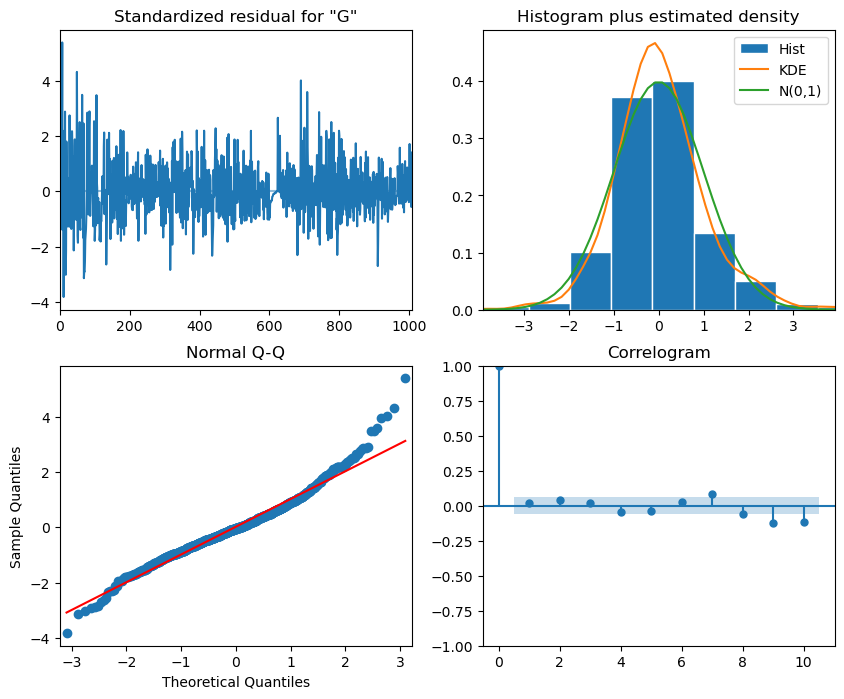

In [69]:
model = SARIMAX(train, order=(3,0,3), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8));

In [70]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=False)

print(pvalue)

[3.78480358e-01 3.66312155e-01 4.93375195e-01 3.29322696e-01
 2.79733520e-01 2.69062171e-01 1.98653367e-02 8.88954562e-03
 7.25403211e-05 5.62485087e-07]


In [71]:
#The residual plots and the results of the Ljungbox test show that the errors are independent and normally distributed. Thus, ARIMA model does not violate the necessary assumptions and can be used to predict Individual household electric power consumption.

In [72]:
test = df.iloc[len_Pr1_train:]

test['naive_seasonal'] = df['Global_active_power'].iloc[len_Pr1_train:].values
test

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,naive_seasonal
1009,2035.328,295.694,347465.44,8674.6,4532.0,2466.0,2035.328
1010,1417.868,214.166,347403.87,6049.8,921.0,604.0,1417.868
1011,1246.536,207.256,347302.12,5326.8,937.0,597.0,1246.536
1012,1636.610,235.964,346675.11,6947.6,2085.0,978.0,1636.610
1013,1426.258,224.076,346157.62,6098.4,1051.0,621.0,1426.258
...,...,...,...,...,...,...,...
1437,2041.536,142.354,345883.85,8660.4,4855.0,2110.0,2041.536
1438,1577.536,137.450,346428.76,6731.2,1871.0,458.0,1577.536
1439,1796.248,132.460,345644.59,7559.4,1096.0,2848.0,1796.248
1440,1431.164,116.128,347812.21,6004.0,1076.0,426.0,1431.164


In [82]:
pred_ARIMA = model_fit.get_prediction(start=1009, end=1441).predicted_mean

# Create an empty series in the DataFrame
df['Global_active_power'] = pd.Series(dtype=float)

# Assign the predictions to the DataFrame using .loc[] and index slicing
df.loc[1009:, 'Global_active_power'] = pred_ARIMA.values

# Print the predictions
print(pred_ARIMA)

# Assign the predictions to another DataFrame called test
test['pred_ARIMA'] = pred_ARIMA.values


1009    1701.436204
1010    1459.960092
1011    1571.581901
1012    1635.165667
1013    1512.697258
           ...     
1437     798.568140
1438     797.302780
1439     796.039425
1440     794.778072
1441     793.518717
Name: predicted_mean, Length: 433, dtype: float64


In [ ]:
#Naive seasonal method can be used to predict the Individual household electric power consumption and can be compared to ARIMA

In [83]:
mape_naive_seasonal = mape(test['Global_active_power'], test['naive_seasonal'])
mape_ARIMA = mape(test['Global_active_power'], test['pred_ARIMA'])

print(mape_naive_seasonal, mape_ARIMA)

0.0 156336211791.1915


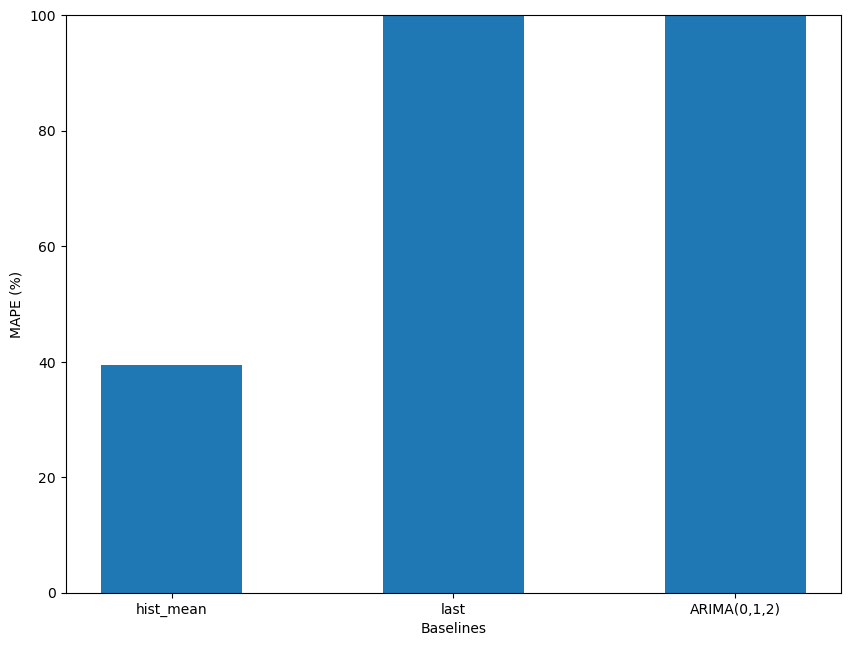

ValueError: Image size of 1666x-230146096 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x500 with 1 Axes>

In [86]:
fig, ax = plt.subplots()
plt.figure(figsize=(10, 5))
x = ['hist_mean', 'last', 'ARIMA(0,1,2)']
y = [mape_hist_mean, mape_last, mape_ARIMA]

ax.bar(x, y, width=0.5)
ax.set_xlabel('Baselines')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 100)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s='{:.2f}'.format(value), ha='center')

plt.tight_layout()

### (C)	Autoregressive  (AR) forecasting

In order to perform Autoregressive forecasting a partial ACF plot is required 

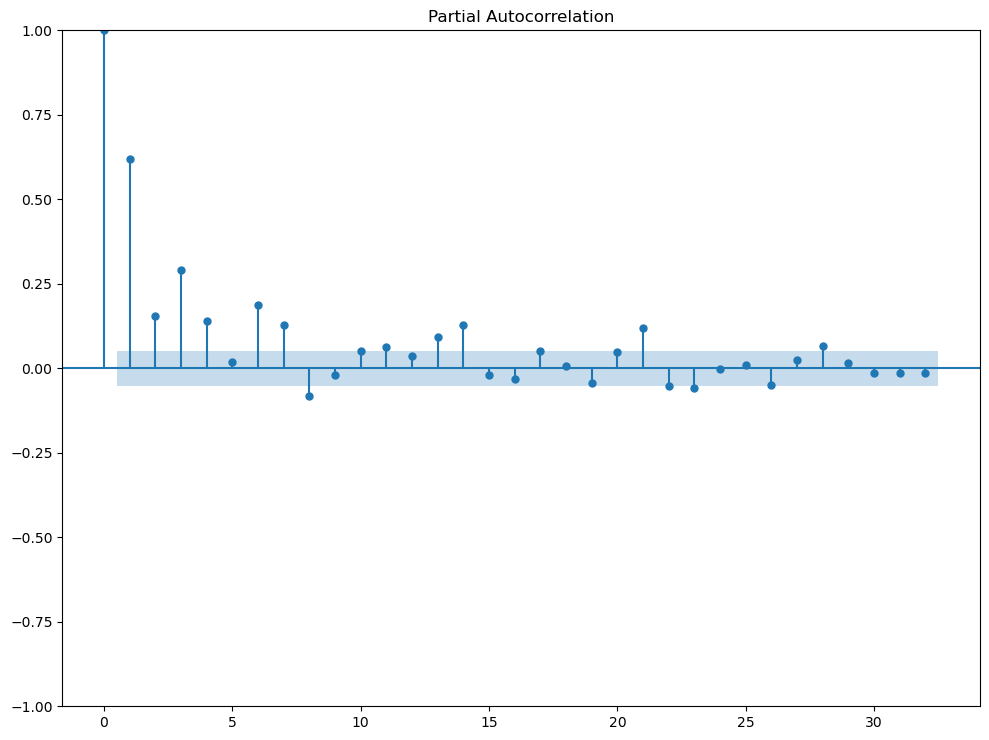

In [75]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['Global_active_power']);

plt.tight_layout()

In [76]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR